<a href="https://colab.research.google.com/github/lpaolariosm/Investigaci-n-de-Operaciones-/blob/main/EJERCICIO11.2.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="color:RED; font-size:26px; font-weight:bold;">
  EJERCICIO:  "Cantidad económica de pedido de varios artículos con limitación de almacén".  RESOLVEREMOS EL EJERCICIO 11.2-3 del libro
  Investigación de Operaciones de Taha, séptima edición.
</p>



<p style="color:ORANGE; font-size:22px; font-weight:bold; margin-bottom:6px;">
  Ejemplo 11.2-3: Cantidad económica de pedido de varios artículos con limitación de almacén
</p>

<p style="color:BLACK; font-size:17px; margin-top:0;">
  Se consideran <b>tres artículos</b> que compiten por un espacio limitado de almacenamiento.
  El objetivo es <b>minimizar</b> el costo total por unidad de tiempo:
  <span style="color:BLACK; font-weight:bold;">
    TCU(y_1,y_2,y_3)=∑(K_i D_i / y_i + h_i y_i / 2)
  </span>,
  sujeto a la restricción de almacén:
  <span style="color:BLACK; font-weight:bold;">
    ∑ a_i y_i ≤ A
  </span>.
</p>

<p style="color:YELLOW; font-size:18px; font-weight:bold; margin-bottom:6px;">
  Datos del problema
</p>

<table style="border-collapse:collapse; font-size:16px; color:#333333;">
  <tr>
    <th style="border:1px solid #999; padding:8px; background:#F2F2F2;">Artículo i</th>
    <th style="border:1px solid #999; padding:8px; background:#F2F2F2;">K<sub>i</sub> ($)</th>
    <th style="border:1px solid #999; padding:8px; background:#F2F2F2;">D<sub>i</sub> (unid/día)</th>
    <th style="border:1px solid #999; padding:8px; background:#F2F2F2;">h<sub>i</sub> ($)</th>
    <th style="border:1px solid #999; padding:8px; background:#F2F2F2;">a<sub>i</sub> (ft²)</th>
  </tr>
  <tr>
    <td style="border:1px solid #999; padding:8px; text-align:center;"><b>1</b></td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">10</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">2</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">0.30</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">1</td>
  </tr>
  <tr>
    <td style="border:1px solid #999; padding:8px; text-align:center;"><b>2</b></td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">5</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">4</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">0.10</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">1</td>
  </tr>
  <tr>
    <td style="border:1px solid #999; padding:8px; text-align:center;"><b>3</b></td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">15</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">4</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">0.20</td>
    <td style="border:1px solid #999; padding:8px; text-align:center;">1</td>
  </tr>
</table>

<p style="color:#333333; font-size:17px; margin-top:10px;">
  <b>Área total disponible para almacenamiento:</b>
  <span style="color:YELLOW; font-weight:bold;">A = 25 ft²</span>
</p>

<p style="color:ORANGE; font-size:18px; font-weight:bold; margin-bottom:6px;">
  Resultado esperado (aprox.)
</p>

<ul style="color:#333333; font-size:17px; margin-top:0;">
  <li><b>y<sub>1</sub></b> ≈ <span style="color:YELLOW; font-weight:bold;">6.34</span> unidades</li>
  <li><b>y<sub>2</sub></b> ≈ <span style="color:YELLOW; font-weight:bold;">7.09</span> unidades</li>
  <li><b>y<sub>3</sub></b> ≈ <span style="color:YELLOW; font-weight:bold;">11.57</span> unidades</li>
</ul>


In [1]:
import numpy as np
import sympy as sp
import scipy.optimize as opt


In [2]:
# Símbolos
lam = sp.Symbol('lam', real=True)
Ki, Di, hi, ai = sp.symbols('Ki Di hi ai', positive=True, real=True)

# y(lam) según condiciones de Lagrange del libro:
# -KiDi/yi^2 + hi/2 - lam*ai = 0  => yi = sqrt(2KiDi / (hi - 2 lam ai))
y_lam_expr = sp.sqrt( (2*Ki*Di) / (hi - 2*lam*ai) )
y_lam_expr


sqrt(2)*sqrt(Di)*sqrt(Ki)*sqrt(1/(-2*ai*lam + hi))

In [3]:
def eoq_multi_almacen(K, D, h, a, A, tol=1e-9):
    """
    Modelo EOQ de varios artículos con restricción de almacén.
    Implementamos los 3 pasos del método del libro.

    Entradas:
      K, D, h, a : arreglos (n,)
      A : área total disponible
    Salidas:
      y_opt : cantidades óptimas (n,)
      lam_opt : multiplicador de Lagrange (si aplica), si no aplica -> 0
      activa : True si la restricción fue activa (Paso 3), False si no (Paso 2)
    """

    K = np.array(K, dtype=float)
    D = np.array(D, dtype=float)
    h = np.array(h, dtype=float)
    a = np.array(a, dtype=float)

    n = len(K)

    # -------------------------
    # PASO 1: y* no restringido
    # -------------------------
    y_star = np.sqrt(2*K*D/h)

    # -------------------------
    # PASO 2: verificar restricción
    # -------------------------
    uso = np.sum(a * y_star)
    if uso <= A + tol:
        # No se activa la restricción
        lam_opt = 0.0
        return y_star, lam_opt, False

    # -------------------------
    # PASO 3: Lagrange, resolver λ
    # -------------------------
    # Construimos función y_i(lam) con la fórmula simbólica y lambdify
    y_num = sp.lambdify((lam, Ki, Di, hi, ai), y_lam_expr, 'numpy')

    def y_vec(lam_val):
        denom = h - 2*lam_val*a
        # dominio: denom > 0 para todos
        if np.any(denom <= 0):
            return None
        return y_num(lam_val, K, D, h, a)

    def g(lam_val):
        yv = y_vec(lam_val)
        if yv is None:
            # fuera del dominio, devolvemos algo "grande" con signo que ayude al bracket
            return 1e9
        return np.sum(a * yv) - A

    # Necesitamos encontrar un intervalo [lam_lo, lam_hi] donde g cambie de signo.
    # Observación del libro: λ < 0 en este planteamiento (porque está como -λ(...)).
    lam_hi = 0.0   # g(0) > 0 (porque violó)
    lam_lo = -1.0  # intentamos negativo

    # Expandimos hacia la izquierda hasta lograr g(lam_lo) < 0
    while g(lam_lo) > 0:
        lam_lo *= 2.0
        if lam_lo < -1e6:
            raise RuntimeError("No se pudo encontrar bracket para λ (muy negativo). Revisa datos.")

    sol = opt.root_scalar(g, bracket=[lam_lo, lam_hi], method='bisect', xtol=tol)

    lam_opt = sol.root
    y_opt = y_vec(lam_opt)

    return y_opt, lam_opt, True


In [4]:
K = [10, 5, 15]
D = [2, 4, 4]
h = [0.30, 0.10, 0.20]
a = [1, 1, 1]
A = 25

y_opt, lam_opt, activa = eoq_multi_almacen(K, D, h, a, A)

print("¿Restricción activa?:", activa)
print("lambda óptimo =", lam_opt)
print("y óptimo =", y_opt)
print("Uso de almacén sum(a_i*y_i) =", np.sum(np.array(a)*y_opt))


¿Restricción activa?: True
lambda óptimo = -0.3479576325044036
y óptimo = [ 6.33751209  7.08918939 11.57329851]
Uso de almacén sum(a_i*y_i) = 24.999999984846724


In [5]:
y_star = np.sqrt(2*np.array(K)*np.array(D)/np.array(h))
print("y* no restringido =", y_star)
print("Uso no restringido =", np.sum(np.array(a)*y_star), "  (A =", A, ")")


y* no restringido = [11.54700538 20.         24.49489743]
Uso no restringido = 56.0419028116243   (A = 25 )


In [6]:
def TCU(y, K, D, h):
    y = np.array(y, dtype=float)
    return np.sum((np.array(K)*np.array(D))/y + (np.array(h)*y)/2)

def restriccion_almacen(y, a, A):
    # ineq en scipy: fun(x) >= 0
    # A - sum(a_i y_i) >= 0  (equivale a sum(a_i y_i) <= A)
    return A - np.sum(np.array(a)*np.array(y))


In [7]:
K = np.array([10, 5, 15], dtype=float)
D = np.array([2, 4, 4], dtype=float)
h = np.array([0.30, 0.10, 0.20], dtype=float)
a = np.array([1, 1, 1], dtype=float)
A = 25.0

# Punto inicial: EOQ no restringido
y0 = np.sqrt(2*K*D/h)

# Si viola la restricción, lo escalamos para que cumpla (mismo "shape", menor tamaño)
uso0 = np.sum(a*y0)
if uso0 > A:
    y0 = y0 * (A/uso0)  # escala para que sum(a*y0)=A

# Restricciones para SLSQP
cons = (
    {'type': 'ineq', 'fun': lambda y: restriccion_almacen(y, a, A)},
)

# Bounds para asegurar y_i > 0 (por ejemplo, mínimo 1e-9)
bnds = tuple((1e-9, None) for _ in range(len(K)))

sol_scipy = opt.minimize(
    fun=lambda y: TCU(y, K, D, h),
    x0=y0,
    method="SLSQP",
    bounds=bnds,
    constraints=cons
)

sol_scipy


     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 13.623773077481385
           x: [ 6.337e+00  7.089e+00  1.157e+01]
         nit: 10
         jac: [-3.480e-01 -3.480e-01 -3.479e-01]
        nfev: 40
        njev: 10
 multipliers: [ 3.480e-01]

In [8]:
y_lagr, lam_opt, activa = eoq_multi_almacen(K, D, h, a, A)

print("=== Método 3 pasos (Lagrange) ===")
print("Restricción activa?:", activa)
print("lambda óptimo =", lam_opt)
print("y (Lagrange) =", y_lagr)
print("Uso almacén =", np.sum(a*y_lagr))
print("TCU =", TCU(y_lagr, K, D, h))

print("\n=== SciPy minimize (SLSQP) ===")
print("Éxito?:", sol_scipy.success)
print("Mensaje:", sol_scipy.message)
print("y (SciPy) =", sol_scipy.x)
print("Uso almacén =", np.sum(a*sol_scipy.x))
print("TCU =", TCU(sol_scipy.x, K, D, h))

print("\n=== Diferencia (SciPy - Lagrange) ===")
print(sol_scipy.x - y_lagr)


=== Método 3 pasos (Lagrange) ===
Restricción activa?: True
lambda óptimo = -0.3479576325044036
y (Lagrange) = [ 6.33751209  7.08918939 11.57329851]
Uso almacén = 24.999999984846724
TCU = 13.623773075113938

=== SciPy minimize (SLSQP) ===
Éxito?: True
Mensaje: Optimization terminated successfully
y (SciPy) = [ 6.33734658  7.08903057 11.57362285]
Uso almacén = 25.0
TCU = 13.623773077481385

=== Diferencia (SciPy - Lagrange) ===
[-0.00016551 -0.00015882  0.00032434]


In [9]:
def suma_area_lambda(lam_val, K, D, h, a):
    denom = h - 2*lam_val*a
    if np.any(denom <= 0):
        return np.nan
    y = np.sqrt(2*K*D / denom)
    return np.sum(a * y)


In [10]:
lam_vals = np.linspace(lam_opt*1.5, 0.0, 300)
area_vals = [suma_area_lambda(l, K, D, h, a) for l in lam_vals]


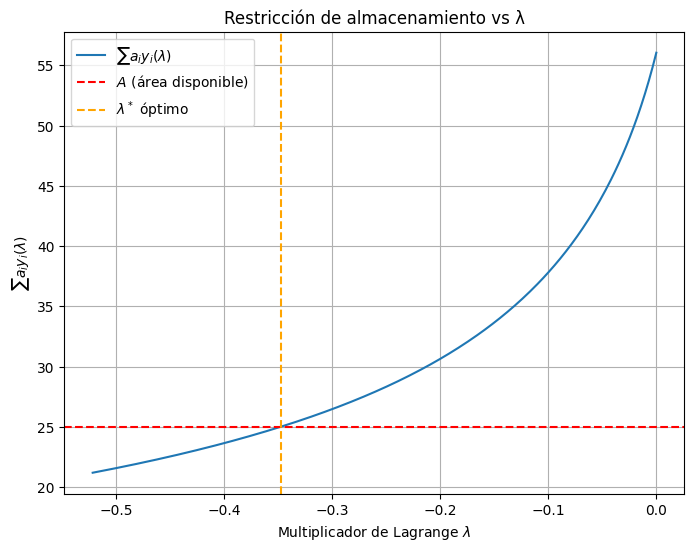

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.plot(lam_vals, area_vals, label=r'$\sum a_i y_i(\lambda)$')
plt.axhline(A, color='red', linestyle='--', label=r'$A$ (área disponible)')
plt.axvline(lam_opt, color='orange', linestyle='--', label=r'$\lambda^*$ óptimo')

plt.xlabel(r'Multiplicador de Lagrange $\lambda$')
plt.ylabel(r'$\sum a_i y_i(\lambda)$')
plt.title('Restricción de almacenamiento vs λ')
plt.legend()
plt.grid(True)

plt.show()
